# Задание Gender recognition
Система распознавания пола диктора

Нужно обучить модель распознавания пола диктора.  
В файле f.txt перечислены женские голоса, в файле m.txt мужские голоса.  
В папке wav_data аудио файлы в формате WAVE 8000 Гц, 16 бит.  
***
**Задача рассматривается как типичная классификация. Возможно не до конца верно выполнен анализ сигнала с точки зрения физ-мата (возможно, я ошибся в расчёте некоторых величин), но это не приведёт к ошибке при последующей классификации по обученный модели, так как создаваемые фичи будут иметь аналогичное распределение и в случае тестовой выборки. Также я не пользовался специальными библиотеками (по типу librosa), предположив, что это не позволено (хоть и не оговорено ТЗ).**  
Импорт библиотек и данных
***

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import fft, signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
wav_dir = 'wav_data'
f = pd.read_csv('f.txt', names = ['female'])
m = pd.read_csv('m.txt', names = ['male'])

***
Объявление функций
***

In [3]:
# Function declarations
def frequency_spectrum(x, sf):
    x = x - np.average(x)  # centering
    n = len(x)
    k = np.arange(n)
    tarr = n / float(sf)
    frqarr = k / float(tarr)
    frqarr = frqarr[range(n // 2)]
    x = fft.fft(x) / n  # FFT and normalization
    x = x[range(n // 2)]
    return frqarr, abs(x), tarr

def plot_feature_importances_mydata(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(df))
    plt.xlabel('Variable importance')
    plt.ylabel('Feature name')

***
Создание фич из доступных записей голоса
***

In [4]:
mean = []
stddev = []
median = []
mode = []
var = []
stddev = []
fundfreq = []
domfreq = []
meanfund = []

for fem in f.female:
    if 'wav2' not in fem:
        sr, y = wavfile.read(wav_dir + '/' + fem) # reading file with female voice
        t = np.arange(len(y)) / float(sr)
        frq, X, coef = frequency_spectrum(y, sr) # FFT function
        avg = np.average(frq, weights = X)
        mean.append(avg) # mean
        order = np.argsort(frq)
        cdf = np.cumsum(X[order])
        median.append(frq[order][np.searchsorted(cdf, cdf[-1] // 2)]) # median
        mode.append(frq[np.argmax(X)]) # mode
        dev = X * (frq - avg) ** 2
        var.append(dev.sum() / (X.sum() - 1)) # variance
        stddev.append(np.sqrt(dev.sum() / (X.sum() - 1))) # standard deviation
        peaks = signal.find_peaks(X, height = X.max()/5, distance = 100)[0] # finding peaks
        prominences = signal.peak_prominences(X, peaks)[0] # finding amplitudes of peaks
        fundfreq.append(peaks[0]/coef) # (first) fundamental frequency
        domfreq.append(peaks[np.where(prominences == prominences.max())[0][0]]) # dominant frequency
        meanfund.append((peaks/coef).mean()) # mean of fundamental frequencies
    else:
        f = f.drop(index = f[f.female == fem].index)
f.reset_index(inplace = True, drop = True)

f_df = f.copy()
f_df['mean'] = mean
f_df['stddev'] = stddev
f_df['median'] = median
f_df['mode'] = mode
f_df['var'] = var
f_df['fund'] = fundfreq
f_df['dom'] = domfreq
f_df['fundmean'] = meanfund

mean = []
stddev = []
median = []
mode = []
var = []
stddev = []
fundfreq = []
domfreq = []
meanfund = []

for mal in m.male:
    if 'wav2' not in mal:
        sr, y = wavfile.read(wav_dir + '/' + mal) # reading file with male voice
        t = np.arange(len(y)) / float(sr)
        frq, X, coef = frequency_spectrum(y, sr) # FFT function
        avg = np.average(frq, weights = X)
        mean.append(avg) # mean
        order = np.argsort(frq)
        cdf = np.cumsum(X[order])
        median.append(frq[order][np.searchsorted(cdf, cdf[-1] // 2)]) # median
        mode.append(frq[np.argmax(X)]) # mode
        dev = X * (frq - avg) ** 2
        var.append(dev.sum() / (X.sum() - 1)) # variance
        stddev.append(np.sqrt(dev.sum() / (X.sum() - 1))) # standard deviation
        peaks = signal.find_peaks(X, height = X.max()/5, distance = 100)[0] # finding peaks
        prominences = signal.peak_prominences(X, peaks)[0] # finding amplitudes of peaks
        fundfreq.append(peaks[0]/coef) # (first) fundamental frequency
        domfreq.append(peaks[np.where(prominences == prominences.max())[0][0]]) # dominant frequency
        meanfund.append((peaks/coef).mean()) # mean of fundamental frequencies
    else:
        m = m.drop(index = f[f.female == fem].index)
m.reset_index(inplace = True, drop = True)

m_df = m.copy()
m_df['mean'] = mean
m_df['stddev'] = stddev
m_df['median'] = median
m_df['mode'] = mode
m_df['var'] = var
m_df['fund'] = fundfreq
m_df['dom'] = domfreq
m_df['fundmean'] = meanfund

In [5]:
df = pd.DataFrame()
for i in f_df.columns[1:]:
    df[i] = pd.concat([f_df[i], m_df[i]])
fem = pd.Series(f_df.shape[0] * [1])
mal = pd.Series(m_df.shape[0] * [0])
df['sex'] = pd.concat([fem, mal])
df.reset_index(drop = True)

,mean,stddev,median,mode,var,fund,dom,fundmean,sex
0,774.072182,625.066367,532.263348,458.892892,3.907080e+05,229.282673,1401,541.565673,1
1,934.053803,910.075927,532.587033,277.148794,8.282382e+05,236.441504,817,394.860705,1
2,776.376454,570.220042,666.954810,467.175719,3.251509e+05,221.677952,1216,642.289776,1
3,918.640423,918.178353,473.682408,466.833328,8.430515e+05,210.129790,1704,334.440601,1
4,1015.759540,720.797502,814.266036,269.237929,5.195490e+05,208.480697,904,726.836512,1
...,...,...,...,...,...,...,...,...,...
199,1512.973185,1087.054076,1246.583253,304.523580,1.181687e+06,151.299326,791,1532.655025,0
200,1185.976242,839.814697,997.435634,508.770130,7.052887e+05,260.744692,2480,738.761973,0
201,1678.628365,1131.997477,1366.106543,654.987487,1.281418e+06,165.534501,1832,1765.035709,0
202,1475.809450,1059.410394,1168.846611,372.651605,1.122350e+06,249.702735,1567,451.724138,0


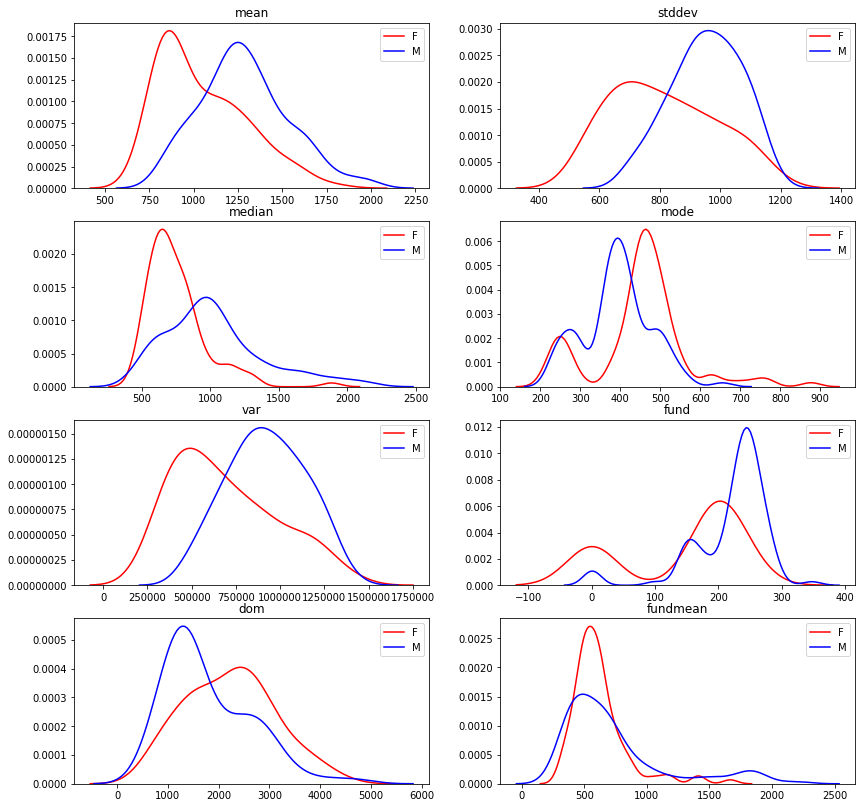

In [6]:
k = (df.shape[1] - 1)//2
r = 2
plt.subplots(k, r, figsize=(14, 14))
for i in range(1, 9):
    plt.subplot(k, r, i)
    plt.title(df.columns[i-1])
    sns.kdeplot(df.loc[df['sex'] == 1, df.columns[i-1]], color= 'red', label='F')
    sns.kdeplot(df.loc[df['sex'] == 0, df.columns[i-1]], color= 'blue', label='M')

***
Очень странная зависимость по чистому mean frequency, а именно не понятно, почему пик женских голосов находится на более низких частотах, чем пик мужских. Можно предположить, что это связано с неотсеянными шумами, правда такое предположение по идее не должно выдерживать критики при таким количестве исследуемых wav-файлов. Также вероятно, что неверно выполнена математическая обработка файлов.  
Обратную ситуацию показывает вполне логичное распределение доминирующей частоты (dom), а также моды (mode).
***
## Обучение моделей и выбор лучшей
***

In [7]:
train, test = train_test_split(df, random_state = 0, test_size = 0.33)
scaler = StandardScaler()
scaler.fit(train.iloc[:, :-2])
X_train = scaler.transform(train.iloc[:, :-2])
X_test = scaler.transform(test.iloc[:, :-2])
y_train = train['sex'].tolist()
y_test = test['sex'].tolist()

In [8]:
# Train decision tree model
tree = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)
print("Decision Tree")
print("Accuracy on training set: {:.2f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Decision Tree
Accuracy on training set: 1.00
Accuracy on test set: 0.868


In [9]:
# Train random forest model
forest = RandomForestClassifier(n_estimators = 5, random_state = 0).fit(X_train, y_train)
print('Random Forests')
print('Accuracy on training set: {:.2f}'.format(forest.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test, y_test)))

Random Forests
Accuracy on training set: 0.99
Accuracy on test set: 0.853


In [10]:
# Train gradient boosting model
gbrt = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
print('Gradient Boosting')
print('Accuracy on training set: {:.2f}'.format(gbrt.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(gbrt.score(X_test, y_test)))

Gradient Boosting
Accuracy on training set: 1.00
Accuracy on test set: 0.868


In [11]:
# Train support vector machine model
svm = SVC().fit(X_train, y_train)
print('Support Vector Machine')
print('Accuracy on training set: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(svm.score(X_test, y_test)))

Support Vector Machine
Accuracy on training set: 0.88
Accuracy on test set: 0.794


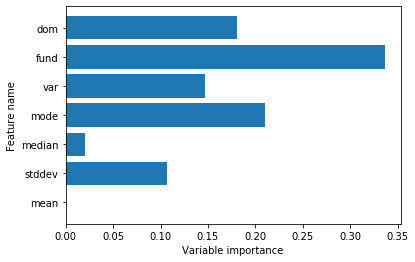

In [12]:
# Plot variable importance for decision tree
plot_feature_importances_mydata(tree)

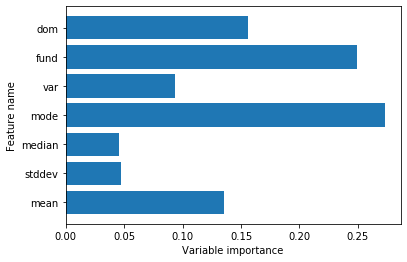

In [13]:
# Plot variable importance for random forest
plot_feature_importances_mydata(forest)

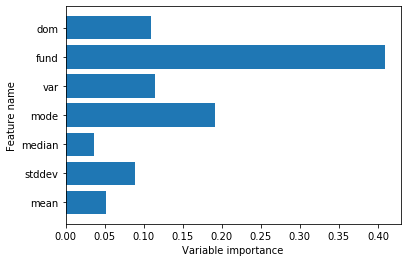

In [14]:
# Plot variable importance gradient boosting model
plot_feature_importances_mydata(gbrt)

In [15]:
# Train final model
final_model = GradientBoostingClassifier(random_state = 0).fit(scaler.transform(df.iloc[:, :-2]), df['sex'].tolist())

## Выводы  
1) странная зависимость в вопросе средней частоты голосов возможно объяснима шумами, присутствующими на записи. Правда, исходя из feature importance графиков выходит, что это не столь важно, так как наиболее важными стали показатели фундаментальной частоты, а так же моды и дисперсии (по этой же причине не проводилась фильтрация low pass фильтром);  
2) с целью улучшения качества работы модели следует увеличить число записей для анализа, это же позволит получить более верную оценку;  
3) при увеличении числа записей можно было бы перейти к кросс-валидации в качестве дополнительной меры избегания переобучения.